In [1]:
import pandas
import seaborn
import time

from lib.compiler import Compiler
from lib.models.generic_v0.model import mappable_params

from lib.models.aft20barzur import BitcoinSM as AFT20BarZur
from lib.models.fc16sapirshtein import BitcoinSM as FC16Sapirshtein

from lib.models.generic_v1 import protocols as g1
from lib.models.generic_v1.model import SingleAgent as G1Model

from lib.models.generic_v0.bitcoin import Bitcoin as G0Bitcoin
from lib.models.generic_v0.model import SelfishMining as G0Model

In [2]:
network = mappable_params

models = []
implicit_mdps = []


def add_model(*, implicit_mdp, **model):
    models.append(model)
    implicit_mdps.append(implicit_mdp)


add_model(
    problem="ref-fc16",
    model="fc16sapirshtein",
    force_consider_own=True,
    merge_isomorphic=True,
    truncate_common_chain=True,
    collect_garbage=True,
    reward_common_chain=True,
    protocol="bitcoin",
    implicit_mdp=lambda c: FC16Sapirshtein(
        **network,
        maximum_dag_size=c,
        maximum_fork_length=0,
    ),
)

add_model(
    problem="ref-aft20",
    model="aft20barzur",
    force_consider_own=True,
    merge_isomorphic=True,
    truncate_common_chain=True,
    collect_garbage=True,
    reward_common_chain=True,
    protocol="bitcoin",
    implicit_mdp=lambda c: AFT20BarZur(
        **network, maximum_dag_size=c, maximum_fork_length=0
    ),
)


# our baseline: garbage collection + common chain truncation
# we want to compare to:
# - no common chain truncation (all infinite)
# - no garbage collection (infinite for protocols that allow stale blocks)
# - plus force-consider-own
# - plus merge-isomorphic
# - plus both


def add_problem(
    problem,
    *,
    collect_garbage=True,
    truncate_common_chain=True,
    force_consider_own=False,
    merge_isomorphic=False,
):
    def f(protocol_s, protocol_C, **protocol_args):
        model_args = dict(
            force_consider_own=force_consider_own,
            merge_isomorphic=merge_isomorphic,
            truncate_common_chain=truncate_common_chain,
            collect_garbage=collect_garbage,
            reward_common_chain=True,
        )
        add_model(
            problem=problem,
            model="generic-v1",
            protocol=protocol_s,
            **model_args,
            implicit_mdp=lambda c: G1Model(
                protocol_C,
                **protocol_args,
                **network,
                **model_args,
                dag_size_cutoff=c,
            ),
        )

    f("bitcoin", g1.Bitcoin)
    f("ethereum_3", g1.Ethereum, h=3)
    f("byzantium_3", g1.Byzantium, h=3)
    f("ghostdag_3", g1.Ghostdag, k=3)
    f("parallel_3", g1.Parallel, k=3)


add_problem("v1")
# add_problem("v1-gc", collect_garbage=False)
# add_problem("v1-tc", truncate_common_chain=False)
add_problem("v1+fc", force_consider_own=True)
add_problem("v1+n", merge_isomorphic=True)
add_problem("v1+fc+n", force_consider_own=True, merge_isomorphic=True)


add_model(
    problem="v0+fc+n",
    model="generic-v0",
    force_consider_own=True,
    merge_isomorphic=True,
    truncate_common_chain=True,
    collect_garbage=True,
    reward_common_chain=True,
    protocol="bitcoin",
    implicit_mdp=lambda c: G0Model(
        G0Bitcoin(),
        **network,
        maximum_size=c,
        force_consider_own=True,
        merge_isomorphic=True,
    ),
)

add_model(
    problem="v0",
    model="generic-v0",
    force_consider_own=False,
    merge_isomorphic=False,
    truncate_common_chain=True,
    collect_garbage=True,
    reward_common_chain=True,
    protocol="bitcoin",
    implicit_mdp=lambda c: G0Model(
        G0Bitcoin(),
        **network,
        maximum_size=c,
        force_consider_own=False,
        merge_isomorphic=False,
    ),
)

models = pandas.DataFrame(models)
models

,problem,model,force_consider_own,merge_isomorphic,truncate_common_chain,collect_garbage,reward_common_chain,protocol
0,ref-fc16,fc16sapirshtein,True,True,True,True,True,bitcoin
1,ref-aft20,aft20barzur,True,True,True,True,True,bitcoin
2,v1,generic-v1,False,False,True,True,True,bitcoin
3,v1,generic-v1,False,False,True,True,True,ethereum_3
4,v1,generic-v1,False,False,True,True,True,byzantium_3
5,v1,generic-v1,False,False,True,True,True,ghostdag_3
6,v1,generic-v1,False,False,True,True,True,parallel_3
7,v1+fc,generic-v1,True,False,True,True,True,bitcoin
8,v1+fc,generic-v1,True,False,True,True,True,ethereum_3
9,v1+fc,generic-v1,True,False,True,True,True,byzantium_3


In [3]:
!mkdir -p 5-generated-mdps

In [4]:
from IPython.display import display, clear_output
import gc
import psutil
import pickle
import gzip

max_size = 100000
# max_size = 5000
aborts = []
size_log = []


def get_rss():
    gc.collect()
    return psutil.Process().memory_info().rss / 1024**3  # GiB


def explore(m):
    c = Compiler(m)
    while not_done := c.explore(steps=1000):
        if c.n_states > max_size:
            break
    done = not not_done
    return (done, c)


def explore_row_limit(idx, row, dag_size_limit):
    m = implicit_mdps[idx](dag_size_limit)
    start_time = time.monotonic()
    done, c = explore(m)

    info = row.to_dict() | dict(
        dag_size_limit=dag_size_limit,
        size=c.n_states,
        time_spent=time.monotonic() - start_time,
        rss=get_rss(),
    )

    # report to stdout
    print(
        "\r"
        + "\t".join(
            [
                f"{k}: {info[k]}"
                for k in [
                    "problem",
                    "protocol",
                    "dag_size_limit",
                    "size",
                    "time_spent",
                    "rss",
                ]
            ]
            + [f"done: {done}                      "]
        ),
        end="",
    )

    if not done:
        aborts.append(info)
    else:
        mdp_key = format(abs(hash(frozenset(info.items()))), "08x")[0:8]
        size_log.append(info | dict(mdp=mdp_key))
        with gzip.open(f"5-generated-mdps/mdp-{mdp_key}.pkl.gz", "wb") as f:
            pickle.dump(c.mdp(finish_exploration=False), f)

    return done

In [5]:
for idx, row in models.iterrows():
    dag_size_limit = 1
    while True:
        dag_size_limit += 1

        if row["problem"].startswith("ref") and dag_size_limit >= 16:
            break

        done = explore_row_limit(idx, row, dag_size_limit)
        if not done:
            break

problem: ref-fc16	protocol: bitcoin	dag_size_limit: 2	size: 3	time_spent: 0.00023024399979476584	rss: 0.172882080078125	done: True                      

problem: ref-fc16	protocol: bitcoin	dag_size_limit: 5	size: 31	time_spent: 0.0010280249998686486	rss: 0.173004150390625	done: True                      

problem: ref-fc16	protocol: bitcoin	dag_size_limit: 6	size: 47	time_spent: 0.001537694000035117	rss: 0.173126220703125	done: True                      

problem: ref-fc16	protocol: bitcoin	dag_size_limit: 9	size: 117	time_spent: 0.003849495000395109	rss: 0.173126220703125	done: True                      

problem: ref-fc16	protocol: bitcoin	dag_size_limit: 10	size: 147	time_spent: 0.004942290999679244	rss: 0.173248291015625	done: True                      

problem: ref-fc16	protocol: bitcoin	dag_size_limit: 13	size: 259	time_spent: 0.00890535100006673	rss: 0.173370361328125	done: True                      

problem: ref-fc16	protocol: bitcoin	dag_size_limit: 14	size: 303	time_spent: 0.01040690599984373	rss: 0.173492431640625	done: True                      

problem: ref-aft20	protocol: bitcoin	dag_size_limit: 3	size: 8	time_spent: 0.00022836999960418325	rss: 0.173614501953125	done: True                      

problem: ref-aft20	protocol: bitcoin	dag_size_limit: 5	size: 25	time_spent: 0.0007243740001285914	rss: 0.173614501953125	done: True                      

problem: ref-aft20	protocol: bitcoin	dag_size_limit: 7	size: 52	time_spent: 0.001264208999600669	rss: 0.173614501953125	done: True                      

problem: ref-aft20	protocol: bitcoin	dag_size_limit: 9	size: 89	time_spent: 0.002175714000259177	rss: 0.173614501953125	done: True                      

problem: ref-aft20	protocol: bitcoin	dag_size_limit: 11	size: 136	time_spent: 0.003504244999930961	rss: 0.173614501953125	done: True                      

problem: ref-aft20	protocol: bitcoin	dag_size_limit: 13	size: 193	time_spent: 0.004718219999631401	rss: 0.173614501953125	done: True                      

problem: ref-aft20	protocol: bitcoin	dag_size_limit: 15	size: 260	time_spent: 0.006388642999809235	rss: 0.173614501953125	done: True                      

problem: v1	protocol: bitcoin	dag_size_limit: 2	size: 6	time_spent: 0.0021289470005285693	rss: 0.173614501953125	done: True                      

problem: v1	protocol: bitcoin	dag_size_limit: 3	size: 34	time_spent: 0.01023965100011992	rss: 0.173614501953125	done: True                      

problem: v1	protocol: bitcoin	dag_size_limit: 4	size: 267	time_spent: 0.08647077200021158	rss: 0.175445556640625	done: True                      

problem: v1	protocol: bitcoin	dag_size_limit: 5	size: 2332	time_spent: 1.1012501990007877	rss: 0.189849853515625	done: True                      

problem: v1	protocol: bitcoin	dag_size_limit: 6	size: 21327	time_spent: 13.848766597000576	rss: 0.340728759765625	done: True                      

problem: v1	protocol: bitcoin	dag_size_limit: 7	size: 100733	time_spent: 60.5480380049994	rss: 0.9820060729980469	done: False                      

problem: v1	protocol: ethereum_3	dag_size_limit: 3	size: 45	time_spent: 0.017836048000390292	rss: 0.21934127807617188	done: True                      

problem: v1	protocol: ethereum_3	dag_size_limit: 4	size: 327	time_spent: 0.12378197399993951	rss: 0.21909713745117188	done: True                      

problem: v1	protocol: ethereum_3	dag_size_limit: 5	size: 2981	time_spent: 1.588771288999851	rss: 0.21885299682617188	done: True                      

problem: v1	protocol: ethereum_3	dag_size_limit: 6	size: 32961	time_spent: 22.734242538000217	rss: 0.4399223327636719	done: True                      

problem: v1	protocol: ethereum_3	dag_size_limit: 7	size: 100084	time_spent: 63.20851031100028	rss: 0.9644622802734375	done: False                      

problem: v1	protocol: byzantium_3	dag_size_limit: 3	size: 45	time_spent: 0.018707498999901873	rss: 0.22039794921875	done: True                      

problem: v1	protocol: byzantium_3	dag_size_limit: 4	size: 327	time_spent: 0.131112220000432	rss: 0.21990966796875	done: True                      

problem: v1	protocol: byzantium_3	dag_size_limit: 5	size: 2981	time_spent: 1.6270551609995891	rss: 0.21990966796875	done: True                      

problem: v1	protocol: byzantium_3	dag_size_limit: 6	size: 33016	time_spent: 23.47243778899974	rss: 0.44061279296875	done: True                      

problem: v1	protocol: byzantium_3	dag_size_limit: 7	size: 100073	time_spent: 66.22179167099966	rss: 0.9642906188964844	done: False                      

problem: v1	protocol: ghostdag_3	dag_size_limit: 3	size: 45	time_spent: 0.018475050999768428	rss: 0.224945068359375	done: True                      

problem: v1	protocol: ghostdag_3	dag_size_limit: 4	size: 352	time_spent: 0.15841436400023667	rss: 0.224700927734375	done: True                      

problem: v1	protocol: ghostdag_3	dag_size_limit: 5	size: 3712	time_spent: 2.341345430999354	rss: 0.224578857421875	done: True                      

problem: v1	protocol: ghostdag_3	dag_size_limit: 6	size: 46966	time_spent: 36.048499821000405	rss: 0.538665771484375	done: True                      

problem: v1	protocol: ghostdag_3	dag_size_limit: 7	size: 100114	time_spent: 64.91680156800066	rss: 0.9342918395996094	done: False                      

problem: v1	protocol: parallel_3	dag_size_limit: 3	size: 90	time_spent: 0.030761252000047534	rss: 0.286285400390625	done: True                      

problem: v1	protocol: parallel_3	dag_size_limit: 4	size: 206	time_spent: 0.07129171099950327	rss: 0.282135009765625	done: True                      

problem: v1	protocol: parallel_3	dag_size_limit: 5	size: 1189	time_spent: 0.5703969420001158	rss: 0.2818946838378906	done: True                      

problem: v1	protocol: parallel_3	dag_size_limit: 6	size: 9122	time_spent: 5.335933156000465	rss: 0.2779884338378906	done: True                      

problem: v1	protocol: parallel_3	dag_size_limit: 7	size: 82753	time_spent: 58.426416858000266	rss: 0.9169044494628906	done: True                      

problem: v1	protocol: parallel_3	dag_size_limit: 8	size: 100206	time_spent: 67.28746706499987	rss: 1.0665931701660156	done: False                      

problem: v1+fc	protocol: bitcoin	dag_size_limit: 4	size: 58	time_spent: 0.02027051300046878	rss: 0.22593307495117188	done: True                      

problem: v1+fc	protocol: bitcoin	dag_size_limit: 5	size: 186	time_spent: 0.07746413499990012	rss: 0.22593307495117188	done: True                      

problem: v1+fc	protocol: bitcoin	dag_size_limit: 6	size: 549	time_spent: 0.24624774800031446	rss: 0.22568893432617188	done: True                      

problem: v1+fc	protocol: bitcoin	dag_size_limit: 7	size: 1650	time_spent: 0.9416160279997712	rss: 0.22544479370117188	done: True                      

problem: v1+fc	protocol: bitcoin	dag_size_limit: 8	size: 4968	time_spent: 3.287593576999825	rss: 0.23093795776367188	done: True                      

problem: v1+fc	protocol: bitcoin	dag_size_limit: 9	size: 15172	time_spent: 12.01616819299943	rss: 0.3317680358886719	done: True                      

problem: v1+fc	protocol: bitcoin	dag_size_limit: 10	size: 46756	time_spent: 41.68892638199941	rss: 0.6686820983886719	done: True                      

problem: v1+fc	protocol: bitcoin	dag_size_limit: 11	size: 100126	time_spent: 87.12275289399986	rss: 1.2576560974121094	done: False                      

problem: v1+fc	protocol: ethereum_3	dag_size_limit: 4	size: 78	time_spent: 0.034412173999953666	rss: 0.23248672485351562	done: True                      

problem: v1+fc	protocol: ethereum_3	dag_size_limit: 5	size: 290	time_spent: 0.1467963580007563	rss: 0.23248672485351562	done: True                      

problem: v1+fc	protocol: ethereum_3	dag_size_limit: 6	size: 1179	time_spent: 0.7250956920006502	rss: 0.23224258422851562	done: True                      

problem: v1+fc	protocol: ethereum_3	dag_size_limit: 7	size: 4123	time_spent: 2.8022302350000245	rss: 0.23077774047851562	done: True                      

problem: v1+fc	protocol: ethereum_3	dag_size_limit: 8	size: 15257	time_spent: 11.617489101000501	rss: 0.3248939514160156	done: True                      

problem: v1+fc	protocol: ethereum_3	dag_size_limit: 9	size: 57506	time_spent: 49.4537729499998	rss: 0.7517738342285156	done: True                      

problem: v1+fc	protocol: ethereum_3	dag_size_limit: 10	size: 100450	time_spent: 82.92232901500029	rss: 1.1935195922851562	done: False                      

problem: v1+fc	protocol: byzantium_3	dag_size_limit: 4	size: 78	time_spent: 0.037134014000002935	rss: 0.23849105834960938	done: True                      

problem: v1+fc	protocol: byzantium_3	dag_size_limit: 5	size: 290	time_spent: 0.16226472900052613	rss: 0.23849105834960938	done: True                      

problem: v1+fc	protocol: byzantium_3	dag_size_limit: 6	size: 1109	time_spent: 0.7537971789997755	rss: 0.23849105834960938	done: True                      

problem: v1+fc	protocol: byzantium_3	dag_size_limit: 7	size: 3952	time_spent: 3.015079300999787	rss: 0.23849105834960938	done: True                      

problem: v1+fc	protocol: byzantium_3	dag_size_limit: 8	size: 15177	time_spent: 13.143079845000102	rss: 0.3241844177246094	done: True                      

problem: v1+fc	protocol: byzantium_3	dag_size_limit: 9	size: 56770	time_spent: 55.52007611800036	rss: 0.7483787536621094	done: True                      

problem: v1+fc	protocol: byzantium_3	dag_size_limit: 10	size: 100334	time_spent: 91.77336020499934	rss: 1.1921348571777344	done: False                      

problem: v1+fc	protocol: ghostdag_3	dag_size_limit: 4	size: 84	time_spent: 0.0453231040000901	rss: 0.23892974853515625	done: True                      

problem: v1+fc	protocol: ghostdag_3	dag_size_limit: 5	size: 350	time_spent: 0.24447031900035654	rss: 0.23868560791015625	done: True                      

problem: v1+fc	protocol: ghostdag_3	dag_size_limit: 6	size: 1527	time_spent: 1.3312265860004118	rss: 0.23868560791015625	done: True                      

problem: v1+fc	protocol: ghostdag_3	dag_size_limit: 7	size: 6739	time_spent: 7.7438552799994795	rss: 0.243011474609375	done: True                      

problem: v1+fc	protocol: ghostdag_3	dag_size_limit: 8	size: 31192	time_spent: 43.11434466500032	rss: 0.4642906188964844	done: True                      

problem: v1+fc	protocol: ghostdag_3	dag_size_limit: 9	size: 100585	time_spent: 105.93721826099863	rss: 1.1151962280273438	done: False                      

problem: v1+fc	protocol: parallel_3	dag_size_limit: 3	size: 69	time_spent: 0.027987881001536152	rss: 0.2909088134765625	done: True                      

problem: v1+fc	protocol: parallel_3	dag_size_limit: 4	size: 119	time_spent: 0.046277916999315494	rss: 0.2830963134765625	done: True                      

problem: v1+fc	protocol: parallel_3	dag_size_limit: 5	size: 470	time_spent: 0.18878830900030152	rss: 0.2828559875488281	done: True                      

problem: v1+fc	protocol: parallel_3	dag_size_limit: 6	size: 2050	time_spent: 0.9883781129992713	rss: 0.28189849853515625	done: True                      

problem: v1+fc	protocol: parallel_3	dag_size_limit: 7	size: 8674	time_spent: 5.1516504129995155	rss: 0.27652740478515625	done: True                      

problem: v1+fc	protocol: parallel_3	dag_size_limit: 8	size: 31850	time_spent: 22.855503144000977	rss: 0.49088287353515625	done: True                      

problem: v1+fc	protocol: parallel_3	dag_size_limit: 9	size: 96542	time_spent: 81.89636469200013	rss: 1.1671524047851562	done: True                      

problem: v1+fc	protocol: parallel_3	dag_size_limit: 10	size: 101052	time_spent: 82.22353205699983	rss: 1.248809814453125	done: False                      

problem: v1+n	protocol: bitcoin	dag_size_limit: 3	size: 45	time_spent: 0.018510218998926575	rss: 0.2554588317871094	done: True                      

problem: v1+n	protocol: bitcoin	dag_size_limit: 4	size: 198	time_spent: 0.0929740280007536	rss: 0.2549705505371094	done: True                      

problem: v1+n	protocol: bitcoin	dag_size_limit: 5	size: 1090	time_spent: 0.7392543380010466	rss: 0.2549705505371094	done: True                      

problem: v1+n	protocol: bitcoin	dag_size_limit: 6	size: 5724	time_spent: 5.106709878000402	rss: 0.2537498474121094	done: True                      

problem: v1+n	protocol: bitcoin	dag_size_limit: 7	size: 31532	time_spent: 37.0403481430003	rss: 0.4568748474121094	done: True                      

problem: v1+n	protocol: bitcoin	dag_size_limit: 8	size: 100188	time_spent: 113.34138653599985	rss: 1.0711593627929688	done: False                      

problem: v1+n	protocol: ethereum_3	dag_size_limit: 3	size: 78	time_spent: 0.04081726199910918	rss: 0.2576866149902344	done: True                      

problem: v1+n	protocol: ethereum_3	dag_size_limit: 4	size: 231	time_spent: 0.12366178999945987	rss: 0.2567100524902344	done: True                      

problem: v1+n	protocol: ethereum_3	dag_size_limit: 5	size: 1480	time_spent: 1.0521223840005405	rss: 0.2562217712402344	done: True                      

problem: v1+n	protocol: ethereum_3	dag_size_limit: 6	size: 10293	time_spent: 8.98915671100076	rss: 0.2670555114746094	done: True                      

problem: v1+n	protocol: ethereum_3	dag_size_limit: 7	size: 77694	time_spent: 78.811966063	rss: 0.8525047302246094	done: True                      

problem: v1+n	protocol: ethereum_3	dag_size_limit: 8	size: 100621	time_spent: 106.78993518300013	rss: 1.0306205749511719	done: False                      

problem: v1+n	protocol: byzantium_3	dag_size_limit: 3	size: 78	time_spent: 0.04563812800006417	rss: 0.26148223876953125	done: True                      

problem: v1+n	protocol: byzantium_3	dag_size_limit: 4	size: 231	time_spent: 0.13804242500009423	rss: 0.26050567626953125	done: True                      

problem: v1+n	protocol: byzantium_3	dag_size_limit: 5	size: 1480	time_spent: 1.134244127999409	rss: 0.26050567626953125	done: True                      

problem: v1+n	protocol: byzantium_3	dag_size_limit: 6	size: 9879	time_spent: 9.486779382999885	rss: 0.26305389404296875	done: True                      

problem: v1+n	protocol: byzantium_3	dag_size_limit: 7	size: 72927	time_spent: 86.13406276200112	rss: 0.8066329956054688	done: True                      

problem: v1+n	protocol: byzantium_3	dag_size_limit: 8	size: 100279	time_spent: 113.62294669500079	rss: 1.0341453552246094	done: False                      

problem: v1+n	protocol: ghostdag_3	dag_size_limit: 3	size: 41	time_spent: 0.019731339998543262	rss: 0.26258087158203125	done: True                      

problem: v1+n	protocol: ghostdag_3	dag_size_limit: 4	size: 228	time_spent: 0.13272480700106826	rss: 0.26184844970703125	done: True                      

problem: v1+n	protocol: ghostdag_3	dag_size_limit: 5	size: 1581	time_spent: 1.1913207079996937	rss: 0.26184844970703125	done: True                      

problem: v1+n	protocol: ghostdag_3	dag_size_limit: 6	size: 12644	time_spent: 12.745359307999024	rss: 0.2823905944824219	done: True                      

problem: v1+n	protocol: ghostdag_3	dag_size_limit: 7	size: 100085	time_spent: 103.15925359099856	rss: 0.9828300476074219	done: False                      

problem: v1+n	protocol: parallel_3	dag_size_limit: 3	size: 68	time_spent: 0.03029774999959045	rss: 0.29613494873046875	done: True                      

problem: v1+n	protocol: parallel_3	dag_size_limit: 4	size: 152	time_spent: 0.07809654900120222	rss: 0.29418182373046875	done: True                      

problem: v1+n	protocol: parallel_3	dag_size_limit: 5	size: 473	time_spent: 0.32428583100045216	rss: 0.29393768310546875	done: True                      

problem: v1+n	protocol: parallel_3	dag_size_limit: 6	size: 1654	time_spent: 1.4178815329996723	rss: 0.29320526123046875	done: True                      

problem: v1+n	protocol: parallel_3	dag_size_limit: 7	size: 6386	time_spent: 6.486343624001165	rss: 0.29076385498046875	done: True                      

problem: v1+n	protocol: parallel_3	dag_size_limit: 8	size: 29302	time_spent: 34.92775235499903	rss: 0.46373748779296875	done: True                      

problem: v1+n	protocol: parallel_3	dag_size_limit: 9	size: 100159	time_spent: 132.90232571200067	rss: 1.1843299865722656	done: False                      

problem: v1+fc+n	protocol: bitcoin	dag_size_limit: 4	size: 45	time_spent: 0.02370939599859412	rss: 0.2626495361328125	done: True                      

problem: v1+fc+n	protocol: bitcoin	dag_size_limit: 5	size: 120	time_spent: 0.07633033199999772	rss: 0.2616729736328125	done: True                      

problem: v1+fc+n	protocol: bitcoin	dag_size_limit: 6	size: 300	time_spent: 0.21702537599958305	rss: 0.2611846923828125	done: True                      

problem: v1+fc+n	protocol: bitcoin	dag_size_limit: 7	size: 760	time_spent: 0.6246927150004922	rss: 0.2609405517578125	done: True                      

problem: v1+fc+n	protocol: bitcoin	dag_size_limit: 8	size: 1959	time_spent: 2.0719238330002554	rss: 0.2606964111328125	done: True                      

problem: v1+fc+n	protocol: bitcoin	dag_size_limit: 9	size: 5153	time_spent: 6.106551231001504	rss: 0.2580108642578125	done: True                      

problem: v1+fc+n	protocol: bitcoin	dag_size_limit: 10	size: 13794	time_spent: 18.48250472699874	rss: 0.3306427001953125	done: True                      

problem: v1+fc+n	protocol: bitcoin	dag_size_limit: 11	size: 37322	time_spent: 56.229281285999605	rss: 0.6013946533203125	done: True                      

problem: v1+fc+n	protocol: bitcoin	dag_size_limit: 12	size: 100344	time_spent: 166.69658919799986	rss: 1.326690673828125	done: False                      

problem: v1+fc+n	protocol: ethereum_3	dag_size_limit: 4	size: 56	time_spent: 0.034678492998864385	rss: 0.273681640625	done: True                      

problem: v1+fc+n	protocol: ethereum_3	dag_size_limit: 5	size: 186	time_spent: 0.13102364000042144	rss: 0.273193359375	done: True                      

problem: v1+fc+n	protocol: ethereum_3	dag_size_limit: 6	size: 596	time_spent: 0.46572399100114126	rss: 0.273193359375	done: True                      

problem: v1+fc+n	protocol: ethereum_3	dag_size_limit: 7	size: 1794	time_spent: 1.6569329209996795	rss: 0.272705078125	done: True                      

problem: v1+fc+n	protocol: ethereum_3	dag_size_limit: 8	size: 5535	time_spent: 5.87937489900105	rss: 0.2715911865234375	done: True                      

problem: v1+fc+n	protocol: ethereum_3	dag_size_limit: 9	size: 17089	time_spent: 20.47565744200074	rss: 0.3603363037109375	done: True                      

problem: v1+fc+n	protocol: ethereum_3	dag_size_limit: 10	size: 51668	time_spent: 69.0419898250002	rss: 0.7239837646484375	done: True                      

problem: v1+fc+n	protocol: ethereum_3	dag_size_limit: 11	size: 100435	time_spent: 142.75658481100072	rss: 1.2507209777832031	done: False                      

problem: v1+fc+n	protocol: byzantium_3	dag_size_limit: 4	size: 56	time_spent: 0.0370833440010756	rss: 0.2805900573730469	done: True                      

problem: v1+fc+n	protocol: byzantium_3	dag_size_limit: 5	size: 186	time_spent: 0.14375432500128227	rss: 0.2796134948730469	done: True                      

problem: v1+fc+n	protocol: byzantium_3	dag_size_limit: 6	size: 572	time_spent: 0.48192443999869283	rss: 0.2793693542480469	done: True                      

problem: v1+fc+n	protocol: byzantium_3	dag_size_limit: 7	size: 1739	time_spent: 1.7825071639999805	rss: 0.2793693542480469	done: True                      

problem: v1+fc+n	protocol: byzantium_3	dag_size_limit: 8	size: 5354	time_spent: 6.54381832999934	rss: 0.2774162292480469	done: True                      

problem: v1+fc+n	protocol: byzantium_3	dag_size_limit: 9	size: 16243	time_spent: 21.803747726000438	rss: 0.3512687683105469	done: True                      

problem: v1+fc+n	protocol: byzantium_3	dag_size_limit: 10	size: 48864	time_spent: 73.52336437600025	rss: 0.6930656433105469	done: True                      

problem: v1+fc+n	protocol: byzantium_3	dag_size_limit: 11	size: 100160	time_spent: 155.18265027800044	rss: 1.2534523010253906	done: False                      

problem: v1+fc+n	protocol: ghostdag_3	dag_size_limit: 4	size: 57	time_spent: 0.039252071001101285	rss: 0.2828102111816406	done: True                      

problem: v1+fc+n	protocol: ghostdag_3	dag_size_limit: 5	size: 184	time_spent: 0.15515321500060963	rss: 0.2823219299316406	done: True                      

problem: v1+fc+n	protocol: ghostdag_3	dag_size_limit: 6	size: 604	time_spent: 0.5990148150012828	rss: 0.2823219299316406	done: True                      

problem: v1+fc+n	protocol: ghostdag_3	dag_size_limit: 7	size: 2026	time_spent: 2.6874720790001447	rss: 0.2823219299316406	done: True                      

problem: v1+fc+n	protocol: ghostdag_3	dag_size_limit: 8	size: 6914	time_spent: 11.003704889999426	rss: 0.2815399169921875	done: True                      

problem: v1+fc+n	protocol: ghostdag_3	dag_size_limit: 9	size: 23944	time_spent: 46.93642179899871	rss: 0.4164276123046875	done: True                      

problem: v1+fc+n	protocol: ghostdag_3	dag_size_limit: 10	size: 83952	time_spent: 195.7555068870006	rss: 1.0444717407226562	done: True                      

problem: v1+fc+n	protocol: ghostdag_3	dag_size_limit: 11	size: 100819	time_spent: 184.94166985399897	rss: 1.2083053588867188	done: False                      

problem: v1+fc+n	protocol: parallel_3	dag_size_limit: 3	size: 50	time_spent: 0.025840819000222837	rss: 0.3156089782714844	done: True                      

problem: v1+fc+n	protocol: parallel_3	dag_size_limit: 5	size: 191	time_spent: 0.12366552200001024	rss: 0.308380126953125	done: True                      

problem: v1+fc+n	protocol: parallel_3	dag_size_limit: 6	size: 462	time_spent: 0.33940541399897484	rss: 0.307891845703125	done: True                      

problem: v1+fc+n	protocol: parallel_3	dag_size_limit: 7	size: 1047	time_spent: 0.9709984170003736	rss: 0.307647705078125	done: True                      

problem: v1+fc+n	protocol: parallel_3	dag_size_limit: 8	size: 2320	time_spent: 2.418882026000574	rss: 0.307159423828125	done: True                      

problem: v1+fc+n	protocol: parallel_3	dag_size_limit: 9	size: 4967	time_spent: 6.142256006000025	rss: 0.3033332824707031	done: True                      

problem: v1+fc+n	protocol: parallel_3	dag_size_limit: 10	size: 10419	time_spent: 14.261315306001052	rss: 0.3016242980957031	done: True                      

problem: v1+fc+n	protocol: parallel_3	dag_size_limit: 11	size: 22041	time_spent: 34.426938487998996	rss: 0.4293098449707031	done: True                      

problem: v1+fc+n	protocol: parallel_3	dag_size_limit: 12	size: 48151	time_spent: 80.87966238800072	rss: 0.7408332824707031	done: True                      

problem: v1+fc+n	protocol: parallel_3	dag_size_limit: 13	size: 100288	time_spent: 182.42859832700015	rss: 1.3994407653808594	done: False                      

problem: v0+fc+n	protocol: bitcoin	dag_size_limit: 4	size: 104	time_spent: 0.045435473999532405	rss: 0.2825965881347656	done: True                      

problem: v0+fc+n	protocol: bitcoin	dag_size_limit: 5	size: 248	time_spent: 0.1296398650010815	rss: 0.2816200256347656	done: True                      

problem: v0+fc+n	protocol: bitcoin	dag_size_limit: 6	size: 501	time_spent: 0.30923049500052	rss: 0.2811470031738281	done: True                      

problem: v0+fc+n	protocol: bitcoin	dag_size_limit: 7	size: 951	time_spent: 0.6627255519997561	rss: 0.2811470031738281	done: True                      

problem: v0+fc+n	protocol: bitcoin	dag_size_limit: 8	size: 1652	time_spent: 1.2892204700001457	rss: 0.2811470031738281	done: True                      

problem: v0+fc+n	protocol: bitcoin	dag_size_limit: 9	size: 2744	time_spent: 2.3026253250009177	rss: 0.2809257507324219	done: True                      

problem: v0+fc+n	protocol: bitcoin	dag_size_limit: 10	size: 4315	time_spent: 4.067619655999806	rss: 0.2806816101074219	done: True                      

problem: v0+fc+n	protocol: bitcoin	dag_size_limit: 11	size: 6569	time_spent: 6.8597425680000015	rss: 0.2804374694824219	done: True                      

problem: v0+fc+n	protocol: bitcoin	dag_size_limit: 12	size: 9636	time_spent: 10.531323531000453	rss: 0.2804374694824219	done: True                      

problem: v0+fc+n	protocol: bitcoin	dag_size_limit: 13	size: 13796	time_spent: 16.33048462700026	rss: 0.2925224304199219	done: True                      

problem: v0+fc+n	protocol: bitcoin	dag_size_limit: 14	size: 19229	time_spent: 24.149702435001018	rss: 0.2945976257324219	done: True                      

problem: v0+fc+n	protocol: bitcoin	dag_size_limit: 15	size: 26303	time_spent: 35.385506582000744	rss: 0.3247489929199219	done: True                      

problem: v0+fc+n	protocol: bitcoin	dag_size_limit: 16	size: 35256	time_spent: 49.834365916000024	rss: 0.3400077819824219	done: True                      

problem: v0+fc+n	protocol: bitcoin	dag_size_limit: 17	size: 46556	time_spent: 69.42990515600104	rss: 0.36644744873046875	done: True                      

problem: v0+fc+n	protocol: bitcoin	dag_size_limit: 18	size: 60507	time_spent: 94.57693620900136	rss: 0.42954254150390625	done: True                      

problem: v0+fc+n	protocol: bitcoin	dag_size_limit: 19	size: 77689	time_spent: 126.81686024200098	rss: 0.5090789794921875	done: True                      

problem: v0+fc+n	protocol: bitcoin	dag_size_limit: 20	size: 98480	time_spent: 169.7307163229998	rss: 0.6114006042480469	done: True                      

problem: v0	protocol: bitcoin	dag_size_limit: 2	size: 18	time_spent: 0.003584230000342359	rss: 0.6238212585449219	done: True                      

problem: v0	protocol: bitcoin	dag_size_limit: 3	size: 175	time_spent: 0.04796629199881863	rss: 0.6238212585449219	done: True                      

problem: v0	protocol: bitcoin	dag_size_limit: 4	size: 1198	time_spent: 0.5129487630001677	rss: 0.6238212585449219	done: True                      

problem: v0	protocol: bitcoin	dag_size_limit: 5	size: 7296	time_spent: 4.381968944999244	rss: 0.6238212585449219	done: True                      

problem: v0	protocol: bitcoin	dag_size_limit: 6	size: 42041	time_spent: 30.574201432000336	rss: 0.6238212585449219	done: True                      

problem: v0	protocol: bitcoin	dag_size_limit: 7	size: 101241	time_spent: 65.72457292000036	rss: 0.6260185241699219	done: False                      

In [6]:
# locate the upper limit for exploring the non-generic reference models with binary search
for idx, row in models.iterrows():
    if not row["problem"].startswith("ref"):
        continue

    dag_size_limit = 16
    while True:
        dag_size_limit *= 2
        done = explore_row_limit(idx, row, dag_size_limit)
        if not done:
            break

    a = dag_size_limit / 2
    b = dag_size_limit

    while b - a > 1:
        c = round((a + b) / 2)
        done = explore_row_limit(idx, row, c)
        if done:
            a = c
        else:
            b = c

problem: ref-fc16	protocol: bitcoin	dag_size_limit: 32	size: 1698	time_spent: 0.06439653000052203	rss: 0.624420166015625	done: True                      

problem: ref-fc16	protocol: bitcoin	dag_size_limit: 64	size: 6978	time_spent: 0.26295488299911085	rss: 0.624420166015625	done: True                      

problem: ref-fc16	protocol: bitcoin	dag_size_limit: 128	size: 28290	time_spent: 1.6029067070012388	rss: 0.624420166015625	done: True                      

problem: ref-fc16	protocol: bitcoin	dag_size_limit: 256	size: 100166	time_spent: 5.780563258000257	rss: 0.624420166015625	done: False                      

problem: ref-fc16	protocol: bitcoin	dag_size_limit: 192	size: 63938	time_spent: 2.9772050110004784	rss: 0.624420166015625	done: True                      

problem: ref-fc16	protocol: bitcoin	dag_size_limit: 224	size: 87138	time_spent: 4.499282266000591	rss: 0.624420166015625	done: True                      

problem: ref-fc16	protocol: bitcoin	dag_size_limit: 240	size: 100012	time_spent: 5.116297928998392	rss: 0.624420166015625	done: False                      

problem: ref-fc16	protocol: bitcoin	dag_size_limit: 232	size: 93498	time_spent: 5.12070971600042	rss: 0.624420166015625	done: True                      

problem: ref-fc16	protocol: bitcoin	dag_size_limit: 236	size: 96762	time_spent: 5.089399336999122	rss: 0.6244430541992188	done: True                      

problem: ref-fc16	protocol: bitcoin	dag_size_limit: 238	size: 98415	time_spent: 5.260460281000633	rss: 0.6244430541992188	done: True                      

problem: ref-fc16	protocol: bitcoin	dag_size_limit: 239	size: 99247	time_spent: 5.157364867000069	rss: 0.6244926452636719	done: True                      

problem: ref-aft20	protocol: bitcoin	dag_size_limit: 32	size: 1233	time_spent: 0.03277576599975873	rss: 0.6244926452636719	done: True                      

problem: ref-aft20	protocol: bitcoin	dag_size_limit: 64	size: 5025	time_spent: 0.13688573700164852	rss: 0.6244926452636719	done: True                      

problem: ref-aft20	protocol: bitcoin	dag_size_limit: 128	size: 20289	time_spent: 0.8734015539994289	rss: 0.6244926452636719	done: True                      

problem: ref-aft20	protocol: bitcoin	dag_size_limit: 256	size: 81537	time_spent: 3.5203089710012136	rss: 0.6244926452636719	done: True                      

problem: ref-aft20	protocol: bitcoin	dag_size_limit: 512	size: 100709	time_spent: 4.158748734000255	rss: 0.6244926452636719	done: False                      

problem: ref-aft20	protocol: bitcoin	dag_size_limit: 384	size: 100709	time_spent: 4.0958220989996335	rss: 0.6244926452636719	done: False                      

problem: ref-aft20	protocol: bitcoin	dag_size_limit: 320	size: 100709	time_spent: 4.119283517999065	rss: 0.6244926452636719	done: False                      

problem: ref-aft20	protocol: bitcoin	dag_size_limit: 288	size: 100709	time_spent: 4.101651110000603	rss: 0.6244926452636719	done: False                      

problem: ref-aft20	protocol: bitcoin	dag_size_limit: 272	size: 92073	time_spent: 3.587528118998307	rss: 0.6244926452636719	done: True                      

problem: ref-aft20	protocol: bitcoin	dag_size_limit: 280	size: 97581	time_spent: 3.9810432140002376	rss: 0.6244926452636719	done: True                      

problem: ref-aft20	protocol: bitcoin	dag_size_limit: 284	size: 100395	time_spent: 4.109103995999249	rss: 0.6244926452636719	done: False                      

problem: ref-aft20	protocol: bitcoin	dag_size_limit: 282	size: 98983	time_spent: 4.094084811000357	rss: 0.6244926452636719	done: True                      

problem: ref-aft20	protocol: bitcoin	dag_size_limit: 283	size: 99688	time_spent: 4.119853640000656	rss: 0.6244926452636719	done: True                      

In [7]:
size_log = pandas.DataFrame(size_log)
aborts = pandas.DataFrame(aborts)

size_log.to_pickle("5-generated-mdps/success.pkl.gz")
aborts.to_pickle("5-generated-mdps/fail.pkl.gz")

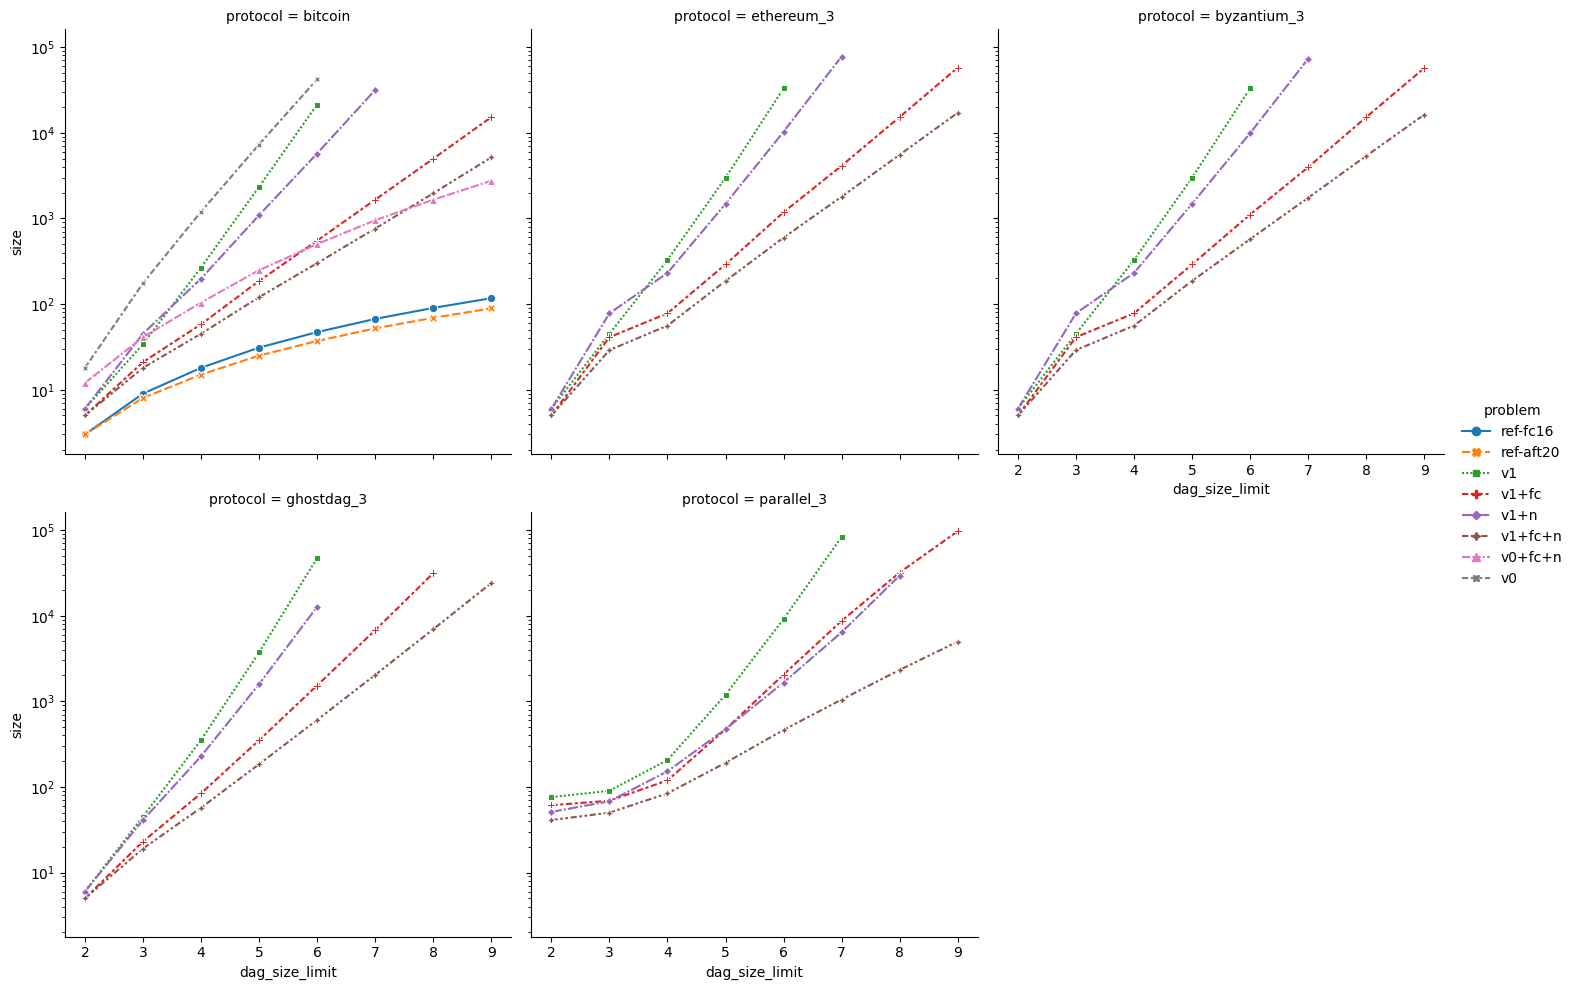

In [8]:
seaborn.relplot(
    data=size_log.query("dag_size_limit < 10"),
    kind="line",
    x="dag_size_limit",
    y="size",
    hue="problem",
    style="problem",
    markers=True,
    col="protocol",
    col_wrap=3,
).set(yscale="log")